# Case Study 1: Loan Application Analysis

Our data set represents loans successfully awarded through the Lending Club platform. Our aim to understand factors that influence interest rate for these loans, and create a model that can predict the interest rate for eligible applicants.

## Data Pre-processing and Exploratory Data Analysis

In [1]:
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt 
import statsmodels.api as sm
from sklearn.feature_selection import SelectKBest, mutual_info_regression
from sklearn.neural_network import MLPRegressor
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split

%matplotlib inline

In [2]:
data = pd.read_csv("loans_full_schema.csv")

data.head()

,emp_title,emp_length,state,homeownership,annual_income,verified_income,debt_to_income,annual_income_joint,verification_income_joint,debt_to_income_joint,...,sub_grade,issue_month,loan_status,initial_listing_status,disbursement_method,balance,paid_total,paid_principal,paid_interest,paid_late_fees
0,global config engineer,3.0,NJ,MORTGAGE,90000.0,Verified,18.01,NaN,NaN,NaN,...,C3,Mar-2018,Current,whole,Cash,27015.86,1999.33,984.14,1015.19,0.0
1,warehouse office clerk,10.0,HI,RENT,40000.0,Not Verified,5.04,NaN,NaN,NaN,...,C1,Feb-2018,Current,whole,Cash,4651.37,499.12,348.63,150.49,0.0
2,assembly,3.0,WI,RENT,40000.0,Source Verified,21.15,NaN,NaN,NaN,...,D1,Feb-2018,Current,fractional,Cash,1824.63,281.80,175.37,106.43,0.0
3,customer service,1.0,PA,RENT,30000.0,Not Verified,10.16,NaN,NaN,NaN,...,A3,Jan-2018,Current,whole,Cash,18853.26,3312.89,2746.74,566.15,0.0
4,security supervisor,10.0,CA,RENT,35000.0,Verified,57.96,57000.0,Verified,37.66,...,C3,Mar-2018,Current,whole,Cash,21430.15,2324.65,1569.85,754.80,0.0


Data Processing involves evaluating multiple factors such as data format correctness, percentage of missing data, and data distribution with respect to our feature of interest, i.e. interest rate, as shown below.

In [3]:
print("Data format is as follows:\n")

print("1. Categorical columns:")
print(data.select_dtypes(["object"]).columns)

print("\n2. Numerical columns:")
print(data.select_dtypes(["int64", "float64"]).columns)

Data format is as follows:

1. Categorical columns:
Index(['emp_title', 'state', 'homeownership', 'verified_income',
       'verification_income_joint', 'loan_purpose', 'application_type',
       'grade', 'sub_grade', 'issue_month', 'loan_status',
       'initial_listing_status', 'disbursement_method'],
      dtype='object')

2. Numerical columns:
Index(['emp_length', 'annual_income', 'debt_to_income', 'annual_income_joint',
       'debt_to_income_joint', 'delinq_2y', 'months_since_last_delinq',
       'earliest_credit_line', 'inquiries_last_12m', 'total_credit_lines',
       'open_credit_lines', 'total_credit_limit', 'total_credit_utilized',
       'num_collections_last_12m', 'num_historical_failed_to_pay',
       'months_since_90d_late', 'current_accounts_delinq',
       'total_collection_amount_ever', 'current_installment_accounts',
       'accounts_opened_24m', 'months_since_last_credit_inquiry',
       'num_satisfactory_accounts', 'num_accounts_120d_past_due',
       'num_accounts

We can see that the data format for all columns is correct.

In [4]:
print("\nThe columns with missing data and their percentage missing values are shown below:")

missing_stats = pd.DataFrame(data.isnull().sum())
missing_stats.columns=["count"]
missing_stats = missing_stats[missing_stats["count"]>0]
missing_stats["pct"] = missing_stats/len(data) * 100
missing_stats = missing_stats.sort_values(by="pct", ascending=False)
missing_stats


The columns with missing data and their percentage missing values are shown below:


,count,pct
verification_income_joint,8545,85.45
annual_income_joint,8505,85.05
debt_to_income_joint,8505,85.05
months_since_90d_late,7715,77.15
months_since_last_delinq,5658,56.58
months_since_last_credit_inquiry,1271,12.71
emp_title,833,8.33
emp_length,817,8.17
num_accounts_120d_past_due,318,3.18
debt_to_income,24,0.24


Before removing any missing data, we analyze its causes and evaluate if we can impute the missing data, as follows:

1. Are the high missing values in the joint application-related data because of individual applications?
2. Are the "months since 90 days late", "months since last delinq", and "num accounts 120d past due" missing data because it is not applicable to the specific application? Can we impute missing data?


#### 1. EDA for Joint-Application Data

In [5]:
total_joint_applns = len(data[data["application_type"]=="joint"])
total_indi_applns = len(data[data["application_type"]=="individual"])

print("Total joint application =", total_joint_applns)
print("Total individual application =", total_indi_applns)

assert len(data)==total_joint_applns+total_indi_applns

Total joint application = 1495
Total individual application = 8505


In [6]:
print("Percentage Missing values in Joint-account data for Joint-account applications:")

round(data[data["application_type"]=="joint"][["verification_income_joint", "annual_income_joint", 
                                         "debt_to_income_joint"]].isnull().sum()/total_joint_applns * 100, 2)


Percentage Missing values in Joint-account data for Joint-account applications:


verification_income_joint    2.68
annual_income_joint          0.00
debt_to_income_joint         0.00
dtype: float64

Hence, only **2.68%** of the joint income verification method data is missing.

We also confirm that data has not been incorrectly filled for joint-account application when it is an individual appication as below:

In [7]:
print("Percentage Missing values in Joint-account data for Individual applications:")

round(data[data["application_type"]=="individual"][["verification_income_joint", "annual_income_joint", 
                                              "debt_to_income_joint"]].isnull().sum()/total_indi_applns * 100, 2)


Percentage Missing values in Joint-account data for Individual applications:


verification_income_joint    100.0
annual_income_joint          100.0
debt_to_income_joint         100.0
dtype: float64

We use the most-frequent method to impute joint income verification missing data as below:

In [8]:
data["verification_income_joint"].value_counts()

Not Verified       611
Source Verified    499
Verified           345
Name: verification_income_joint, dtype: int64

In [9]:
data.loc[(data["application_type"]=="joint") & (data["verification_income_joint"].isna()),
         "verification_income_joint"]="Not Verified"

In [10]:
assert data[data["application_type"]=="joint"]["verification_income_joint"].isna().sum() == 0

For individual applications, we also set these join-account related application data to 0 instead of missing values.

In [11]:
data.loc[(data["application_type"]=="individual"),["verification_income_joint", 
                                                   "annual_income_joint", "debt_to_income_joint"]] = 0

data[["verification_income_joint","annual_income_joint", "debt_to_income_joint"]].isna().sum()

verification_income_joint    0
annual_income_joint          0
debt_to_income_joint         0
dtype: int64

We look at the causes of missing data in "months_since_last_delinq" column

In [12]:
data[["months_since_last_delinq"]].isna().sum()

months_since_last_delinq    5658
dtype: int64

<AxesSubplot:>

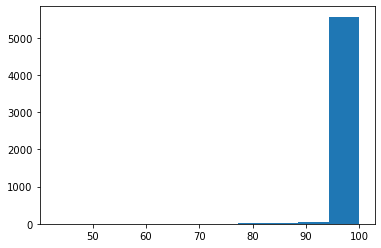

In [13]:
data[data["months_since_last_delinq"].isna()]["account_never_delinq_percent"].hist(grid=False)

Thus, we see that a majority of accounts have never been deliquent, hence we have missing values

<AxesSubplot:ylabel='Frequency'>

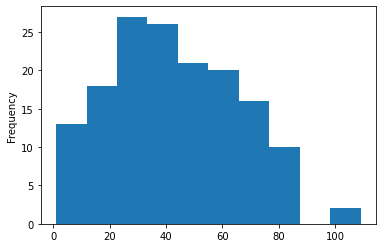

In [14]:
data[(data["account_never_delinq_percent"]==100)]["months_since_last_delinq"].plot.hist()

**Note:** There is a data consistency issue, as we have many observations where account has never been deliquent but we have non-zero values for months since last delinqency.

For now, we just fill missing data for "months_since_last_delinq" using the average value.

In [15]:
data.loc[data["months_since_last_delinq"].isna(), 
         "months_since_last_delinq"] = int(np.mean(data["months_since_last_delinq"]))

assert data["months_since_last_delinq"].isna().sum()==0

We look at the causes of missing data in "months_since_90d_late" column

7715


<AxesSubplot:>

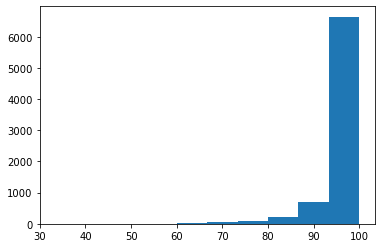

In [16]:
print(data["months_since_90d_late"].isna().sum())

data[data["months_since_90d_late"].isna()]["account_never_delinq_percent"].hist(grid=False)

<AxesSubplot:>

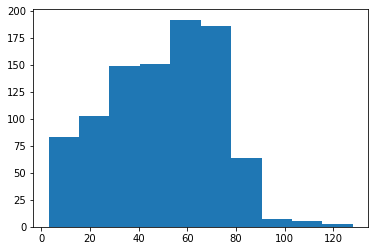

In [17]:
data[data["account_never_delinq_percent"]>90]["months_since_90d_late"].hist(grid=False)

Thus, we see that a majority of accounts have never been deliquent, hence we have missing values.

We impute these missing values using the average value

In [18]:
data.loc[data["months_since_90d_late"].isna(), 
         "months_since_90d_late"] = int(np.mean(data["months_since_90d_late"]))

assert data["months_since_90d_late"].isna().sum()==0

We look at the causes of missing data in "num_accounts_120d_past_due" column

318


<AxesSubplot:>

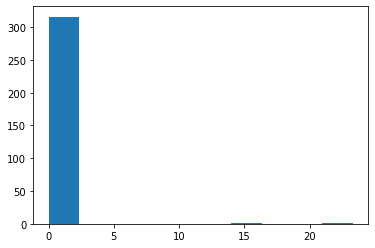

In [19]:
print(data["num_accounts_120d_past_due"].isna().sum())

data[data["num_accounts_120d_past_due"].isna()]["paid_late_fees"].hist(grid=False)

In [20]:
data[data["paid_late_fees"]==0]["num_accounts_120d_past_due"].value_counts()

0.0    9633
Name: num_accounts_120d_past_due, dtype: int64

Thus, most of these accounts are not past the due date.

We put the missing value as zero.

In [21]:
data.loc[data["num_accounts_120d_past_due"].isna(), "num_accounts_120d_past_due"] = 0

assert data["num_accounts_120d_past_due"].isna().sum()==0

We impute these missing values using the average value for "months_since_last_credit_inquiry", "debt_to_income", and "emp_length" columns

In [22]:
data.loc[data["months_since_last_credit_inquiry"].isna(), 
         "months_since_last_credit_inquiry"] = int(np.mean(data["months_since_last_credit_inquiry"]))

assert data["months_since_last_credit_inquiry"].isna().sum()==0

In [23]:
data.loc[data["debt_to_income"].isna(), 
         "debt_to_income"] = int(np.mean(data["debt_to_income"]))

assert data["debt_to_income"].isna().sum()==0

In [24]:
data.loc[data["emp_length"].isna(), 
         "emp_length"] = int(np.mean(data["emp_length"]))

assert data["emp_length"].isna().sum()==0

## Data Modeling

<AxesSubplot:>

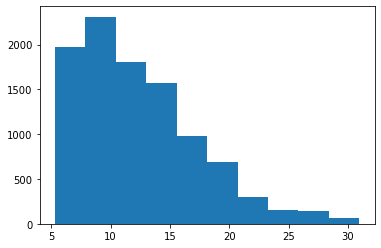

In [25]:
data['interest_rate'].hist(grid=False)

We follow the steps as mentioned below:
* Select a small subset of features for initial analysis, based on business importance
* Create dummy variables for categorical data
* Use feature selection to select best-ranked features
* Create models to predict interest rate

In [26]:
data_2 = data[['emp_length','homeownership', 'annual_income', 'debt_to_income', 'debt_to_income_joint', 
               'loan_status', 'num_mort_accounts', 'account_never_delinq_percent', 'term', 'installment',
               'grade', 'loan_purpose', 'loan_amount', 'public_record_bankrupt', 'total_credit_limit',
               'delinq_2y','interest_rate']]
data_2.head()

,emp_length,homeownership,annual_income,debt_to_income,debt_to_income_joint,loan_status,num_mort_accounts,account_never_delinq_percent,term,installment,grade,loan_purpose,loan_amount,public_record_bankrupt,total_credit_limit,delinq_2y,interest_rate
0,3.0,MORTGAGE,90000.0,18.01,0.00,Current,1,92.9,60,652.53,C,moving,28000,0,70795,0,14.07
1,10.0,RENT,40000.0,5.04,0.00,Current,0,100.0,36,167.54,C,debt_consolidation,5000,1,28800,0,12.61
2,3.0,RENT,40000.0,21.15,0.00,Current,0,93.5,36,71.40,D,other,2000,0,24193,0,17.09
3,1.0,RENT,30000.0,10.16,0.00,Current,0,100.0,36,664.19,A,debt_consolidation,21600,0,25400,0,6.72
4,10.0,RENT,35000.0,57.96,37.66,Current,0,100.0,36,786.87,C,credit_card,23000,0,69839,0,14.07


In [27]:
data_3 = pd.get_dummies(data_2, drop_first=True)
data_3.head()

,emp_length,annual_income,debt_to_income,debt_to_income_joint,num_mort_accounts,account_never_delinq_percent,term,installment,loan_amount,public_record_bankrupt,...,loan_purpose_debt_consolidation,loan_purpose_home_improvement,loan_purpose_house,loan_purpose_major_purchase,loan_purpose_medical,loan_purpose_moving,loan_purpose_other,loan_purpose_renewable_energy,loan_purpose_small_business,loan_purpose_vacation
0,3.0,90000.0,18.01,0.00,1,92.9,60,652.53,28000,0,...,0,0,0,0,0,1,0,0,0,0
1,10.0,40000.0,5.04,0.00,0,100.0,36,167.54,5000,1,...,1,0,0,0,0,0,0,0,0,0
2,3.0,40000.0,21.15,0.00,0,93.5,36,71.40,2000,0,...,0,0,0,0,0,0,1,0,0,0
3,1.0,30000.0,10.16,0.00,0,100.0,36,664.19,21600,0,...,1,0,0,0,0,0,0,0,0,0
4,10.0,35000.0,57.96,37.66,0,100.0,36,786.87,23000,0,...,0,0,0,0,0,0,0,0,0,0


In [28]:
X = data_3.loc[:, data_3.columns!='interest_rate']
y = data_3['interest_rate']

selector = SelectKBest(mutual_info_regression, k=10)
selector.fit(X, y)
X.columns[selector.get_support()]

Index(['debt_to_income', 'term', 'installment', 'loan_amount',
       'total_credit_limit', 'grade_B', 'grade_C', 'grade_D', 'grade_E',
       'grade_F'],
      dtype='object')

In [29]:
X = X.loc[:, X.columns[selector.get_support()]]
X.head()

,debt_to_income,term,installment,loan_amount,total_credit_limit,grade_B,grade_C,grade_D,grade_E,grade_F
0,18.01,60,652.53,28000,70795,0,1,0,0,0
1,5.04,36,167.54,5000,28800,0,1,0,0,0
2,21.15,36,71.40,2000,24193,0,0,1,0,0
3,10.16,36,664.19,21600,25400,0,0,0,0,0
4,57.96,36,786.87,23000,69839,0,1,0,0,0


In [30]:
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=12)

Linear Model - Ordinary Least Squares Estimation

In [31]:
model = sm.OLS(y_train, sm.add_constant(X_train))
model = model.fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:          interest_rate   R-squared:                       0.933
Model:                            OLS   Adj. R-squared:                  0.933
Method:                 Least Squares   F-statistic:                 1.043e+04
Date:                Tue, 12 Apr 2022   Prob (F-statistic):               0.00
Time:                        03:26:14   Log-Likelihood:                -12561.
No. Observations:                7500   AIC:                         2.514e+04
Df Residuals:                    7489   BIC:                         2.522e+04
Df Model:                          10                                         
Covariance Type:            nonrobust                                         
                         coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------
const                  3.9749      0

In [32]:
ols_results = model.predict(sm.add_constant(X_test))

In [33]:
regr = MLPRegressor(random_state=12).fit(X_train, y_train)
regr.score(X_test, y_test)

-2.028779134117176

In [34]:
mlp_results = regr.predict(X_test)

In [35]:
results = pd.DataFrame({"OLS": ols_results, "MLP": mlp_results, "Actual": y_test}).reset_index(drop=True)
results.head()

,OLS,MLP,Actual
0,13.695263,8.937897,15.04
1,6.525926,33.728347,5.31
2,9.935164,-4.571621,11.99
3,10.078855,22.263759,9.44
4,13.886726,12.324905,14.07


<AxesSubplot:xlabel='OLS', ylabel='Actual'>

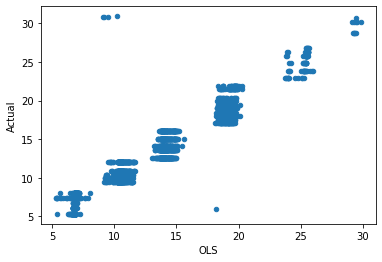

In [36]:
results[["OLS", "Actual"]].plot.scatter(x="OLS", y ="Actual")

<AxesSubplot:xlabel='MLP', ylabel='Actual'>

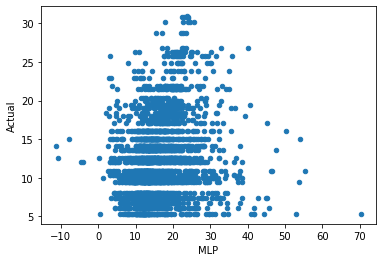

In [37]:
results[["MLP", "Actual"]].plot.scatter(x="MLP", y ="Actual")

## Conclusion

The OLS linear model has an R-square of 0.93, and after visualizing test data predictions, we see that this model is better than the MLP regression model for predicting the loan interest rate.

## Next steps

* Expand feature set to include all features
* Evaluate presence of feature correlation
* Deep-dive into significance level and p-value of features in OLS model